In [89]:
%cd ../src
%ls

[Errno 2] No such file or directory: '../src'
/home/roland/Desktop/Stage_4A/my_diffusion
cuda-keyring_1.0-1_all.deb  parameters.npy
Diffusion_Notebooks/        second_order_parameters_spiral.npy
parameters1.npy             second_order_version1.ipynb
parameters2.npy             second_VE_model.ipynb
parameters3.npy             third_VE_model.ipynb


In [90]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random
import flax
from flax import linen as nn
import optax

import time

import os
import pickle

import matplotlib.pyplot as plt

from torch.utils import data
from torch.utils.data import Dataset

print("the device used is", jax.devices(), jax.default_backend())
print(jax.device_count())

the device used is [CpuDevice(id=0)] cpu
1


# Dataloader and metaparameters

In [91]:
seed = 0
key = random.PRNGKey(seed)
rng = key
batch_size = 512
intermediate_embeding_time_dimension = 128
intermediate_features_embedding = 128
# epsilon = 0.01 # smallest time considered
num_timesteps = 1000

dimension = 2
T_max = 1.0

num_training_iterations = 50_000
ema_rate = 0.99

In [92]:
def generateBatchPoints(key, distribution = 'plus_sign', batch_size=batch_size) :
    if distribution == 'spiral' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= 0., maxval= 1.)**.5
        noise = 0.01*random.normal(key2, shape = (batch_size,2))
        angle = 10*radius # angle from the first axis
        positions = jnp.concatenate( (radius*jnp.cos(angle),radius*jnp.sin(angle)), axis=1  ) + noise
    
    if distribution == 'plus_sign' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= -1., maxval= 1.)
        axis = random.randint(key2, shape  = (batch_size,1), minval=0, maxval=2)
        positions = jnp.concatenate( (radius*axis,radius*(1 - axis)), axis=1  )

    
    return(positions[...,None])

class distribution_dataset(Dataset):
    def __init__(self, key = random.PRNGKey(seed)) : 

        self.points = generateBatchPoints(key, distribution = 'spiral', batch_size = batch_size*50 )

    def __len__(self):
        return self.points.shape[0]//batch_size 

    def __getitem__(self, idx):
        return( self.points[ idx*batch_size:(idx+1)*batch_size , ...])
    
    

In [93]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                  shuffle=False, sampler=None,
                  batch_sampler=None, num_workers=0,
                  pin_memory=False, drop_last=False,
                  timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

In [94]:
rng , subkey = random.split(key)
trainset = distribution_dataset(subkey)
train_dataloader = NumpyLoader(trainset, batch_size=1, shuffle=True)

## useful functions

In [95]:
beta = 1.
M = 1.
gamma = 0.1
Gamma = 2*M**0.5
BETA = lambda t : t*beta
Sigma_xx_0 = 0.
Sigma_vv_0 = gamma*M
Sigma_xx = lambda t : Sigma_xx_0 + jnp.exp(4*BETA(t)/Gamma) - 1 + 4*BETA(t)/Gamma*(Sigma_xx_0 - 1) + 4*(BETA(t)/Gamma)**2*(Sigma_xx_0 - 2) + 16*BETA(t)**2/Gamma**4*Sigma_vv_0
Sigma_xv = lambda t : -BETA(t)*Sigma_xx_0 + 4*BETA(t)/Gamma**2*Sigma_vv_0 - 2*BETA(t)**2/Gamma*(Sigma_xx_0 - 2) - 8*BETA(t)**2/Gamma**3*Sigma_vv_0
Sigma_vv = lambda t : Gamma**2/4*(jnp.exp(4*BETA(t)/Gamma) - 1) + BETA(t)*Gamma + Sigma_vv_0*(1 + 4*(BETA(t)/Gamma)**2 - 4*BETA(t)/Gamma) + BETA(t)**2*(Sigma_xx_0 - 2)

l_HSM = lambda t : jnp.sqrt( Sigma_xx(t)/(Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2) )

L_Cholesky = lambda t : jnp.array([ [jnp.sqrt(Sigma_xx(t)) , jnp.zeros( t.shape ) ] , [ Sigma_xv(t)/jnp.sqrt(Sigma_xx(t)) , jnp.sqrt( (Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2)/Sigma_xx(t) ) ]]).transpose((2,0,1))

# mu for DSM
# def mu(t,x_0,v_0) :
#     return jnp.concatenate([ 2*BETA(t)/Gamma*x_0 + 4*BETA(t)/Gamma**2*v_0 + x_0 , -BETA(t)*x_0 - 2*BETA(t)/Gamma*v_0 + v_0 ], axis = -1 )*jnp.exp(-2*BETA(t)/Gamma)

# mu for HSM (v_0 = 0)
def mu_HSM(t_batch,x_0_batch) :
    batch_size = x_0_batch.shape[0]
    x_0 = x_0_batch
    t = t_batch.flatten()

    # shapes give (2, batch) (batch, dim,1) (batch)  -> (batch, 2, dim) 
    return jnp.array([ 2*BETA(t)/Gamma + 1 , -BETA(t) ]).T.reshape((batch_size,2,1))*x_0.reshape((batch_size,1,dimension))*jnp.exp(-2*BETA(t)/Gamma).reshape((batch_size,1,1))


In [96]:
# test 
batch = jnp.ones((batch_size,2,1))
t_batch = jnp.ones((batch_size,))

print(mu_HSM(t_batch, batch).shape)

print(L_Cholesky(t_batch).shape)

(512, 2, 2)
(512, 2, 2)


In [97]:
L_Cholesky(jnp.array([10]))

Array([[[2.202646e+04, 0.000000e+00],
        [8.671389e-03, 2.202646e+04]]], dtype=float32)

In [98]:
@jax.jit
def PositionalEncoding(time_indices, embed_dimension = intermediate_embeding_time_dimension) :
    """ 
    - time_indices : shape (batch_size,) , should be int between 0 and num_timesteps
    - embed_dimension : dimension of the embeded time, *must be even* for definition of k in the function !
    """ 
     
    magic_number = 1000 # custom magic number addapted for embed_dimension = 128 
    times = time_indices.reshape( (1,-1) )
    k = jnp.arange( 0, embed_dimension//2 ).reshape((-1,1))

    ### might not be the most elegant way to do this ? :
    embedding = jnp.array([ jnp.cos( times/(magic_number**(2.*k/embed_dimension)) ) , jnp.sin( times/(magic_number**(2.*k/embed_dimension)) ) ])
    # embedding shape is (2, embed_dimension/2, batch_size) and should become (batch_size, embed_dim)
    embedding = jnp.transpose(embedding, (2,1,0))
    embedding = embedding.reshape((-1, embed_dimension ))
    ###

    return(embedding)


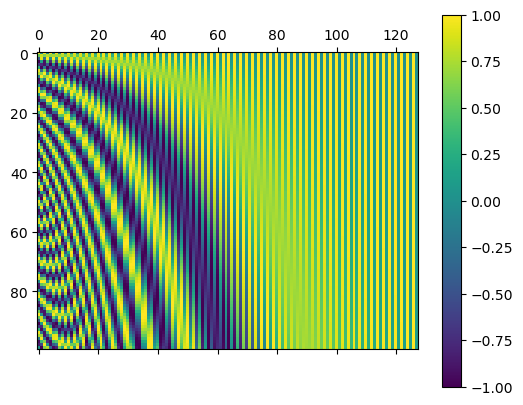

In [99]:
# test 
embedded = PositionalEncoding(jnp.arange(0,100))

plt.matshow(embedded)
plt.colorbar()
plt.show()

In [100]:
class batch_MLP_bloc(nn.Module):                    # create a Flax Module dataclass
  out_dims: int

  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(self.out_dims)(x)       # shape inference
    return x


In [101]:
batch_MLP_embedding_layers = batch_MLP_bloc(out_dims= intermediate_features_embedding) 
batch_MLP_final_layers = batch_MLP_bloc(out_dims= 2)

def generateParameters(key):

    key, key1, key2, key3, key4 = random.split(key,5)

    # useless to put batch_size instead of '1'
    typical_batch = jnp.empty((batch_size, 2,1))
    typical_time_batch = jnp.empty((batch_size,intermediate_embeding_time_dimension))
    typical_embedded_batch = jnp.empty((batch_size, 3*intermediate_features_embedding))
    
    params_times = batch_MLP_embedding_layers.init(key1, typical_time_batch)
    params_positions = batch_MLP_embedding_layers.init(key2, typical_batch)
    params_velocities =  batch_MLP_embedding_layers.init(key3, typical_batch)
    params_global = batch_MLP_final_layers.init(key4, typical_embedded_batch)
    

    parameters = { 'params_times' : params_times,
                'params_positions' : params_positions,
                'params_velocities' : params_velocities,
                'params_global' : params_global }
    
    return(key,parameters)

In [102]:
batch_MLP_embedding_layers = batch_MLP_bloc(out_dims= intermediate_features_embedding) 
batch_MLP_final_layers = batch_MLP_bloc(out_dims= 2)

@jax.jit
def alpha_model(parameters,batch_positions, batch_velocities, time_indices) :

    """
    input :
    - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_vitesses', 'params_global' for the respectives MLP
    - batch : positions batch shape (batch_size, 2, 1)
    - time_indices : shape (batch_size,) should be integers (float of int)
    output :
    - shape (batch_size,2,1)
    """
    time_embedding = PositionalEncoding(time_indices)
    params_times = parameters['params_times']
    params_positions = parameters['params_positions']
    params_velocities = parameters['params_velocities']
    params_global = parameters['params_global']

    time_embedding = batch_MLP_embedding_layers.apply( params_times, time_embedding)
    position_embedding = batch_MLP_embedding_layers.apply( params_positions, batch_positions)
    velocity_embedding = batch_MLP_embedding_layers.apply( params_velocities, batch_velocities)
    
    global_embedding = jnp.concatenate( (time_embedding, position_embedding, velocity_embedding) , axis = 1)

    result = batch_MLP_final_layers.apply( params_global, global_embedding )[:,:,None]

    return(result)

In [103]:
# test 
key, parameters = generateParameters(key)

times = jnp.ones((batch_size,))
batch = random.normal(key, (batch_size,2,1) )
batch_velocities = random.normal(key, (batch_size,2,1) )
result = alpha_model(parameters, batch, batch_velocities, times )
print(result.shape)

(512, 2, 1)


In [120]:
def timeIndeces2RealTime(time_indices ) :
    return( time_indices *1.0/num_timesteps)

@jax.jit
def batch_loss(parameters,batch, key) :
    """
    input :
    - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_vitesses', 'params_global' for the respectives MLP
    - batch : positions batch shape (batch_size, 2, 1)
    """
    key, key2, key3, key4 = random.split(key,4)

    # sampling times
    time_indices = random.randint(key2, shape = (batch_size,), minval= 1, maxval= num_timesteps)
    real_time_batch = timeIndeces2RealTime(time_indices )

    epsilon = random.normal(key3, shape = (batch_size,dimension, 2)) 
    print("d", epsilon[...,None].shape)

    batch_global = mu_HSM(real_time_batch, batch) + (L_Cholesky(real_time_batch)@epsilon[...,None])[...,0].transpose( (0,2,1) ) # shape (batch_size, 2,dim)
    batch_positions = batch_global[:,0,:]
    batch_velocities = batch_global[:,1,:]

    loss = jnp.mean(( epsilon[:,:,1].squeeze() -  alpha_model(parameters,batch_positions, batch_velocities, time_indices).squeeze()  )**2 )
    return(loss)
    

In [121]:
# test 
real_time_batch = jnp.ones((batch_size,))

epsilon = random.normal(key, shape = (batch_size, 2, dimension))

batch_global = L_Cholesky(real_time_batch)@epsilon
print(batch_size)
print(L_Cholesky(real_time_batch).shape)
print(epsilon.shape)
print(batch_global.shape)

512
(512, 2, 2)
(512, 2, 2)
(512, 2, 2)


In [122]:
def train_or_retrieve_model(key, savingFileName = "second_order_parameters.npy") :

    if os.path.isfile(savingFileName) :
        with open(savingFileName, 'rb') as file:
            parameters = pickle.load(file)
    else :
        key, parameters = generateParameters(key)

        learning_rate = 0.001
        optimizer = optax.adam(learning_rate)
        opt_state = optimizer.init(parameters)

        loss_cache = []
        i = 0
        while i < num_training_iterations :

            for batch in train_dataloader :
                batch = batch[0]

                key = random.split(key, 1)[0]
                value, grads = jax.value_and_grad(batch_loss)(parameters, batch, key)
                loss_cache.append(value)
                if i%500 == 0 :
                    print( "step :", str(i), "   -   loss :", str(np.mean(loss_cache)))
                    loss_cache = [] 
                updates, opt_state = optimizer.update(grads, opt_state)
                parameters = optax.apply_updates(parameters, updates)
                i+=1

        with open(savingFileName, 'wb') as file:
            pickle.dump(parameters, file)
    return(parameters)

In [124]:
parameters = train_or_retrieve_model(key)

d (512, 2, 2, 1)


ValueError: Incompatible shapes for matmul arguments: (512, 2, 2) and (512, 2, 2, 1)

In [108]:
def score(parameters,batch_positions, batch_velocities, time_indices) :
    real_time_batch = timeIndeces2RealTime(time_indices )
    return( -l_HSM(real_time_batch)[:,None,None]*alpha_model(parameters,batch_positions, batch_velocities, time_indices) )

In [109]:
# test 
batch_positions = jnp.zeros((batch_size,2,1))
batch_velocities = jnp.zeros((batch_size,2,1))
time_indices = jnp.ones((batch_size,))

sco = score(parameters,batch_positions, batch_velocities, time_indices)
print(sco.shape)

(512, 2, 1)


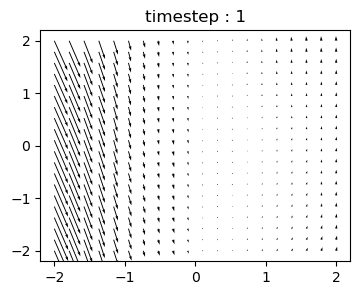

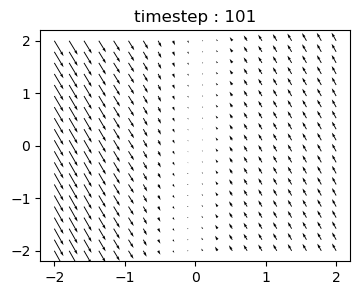

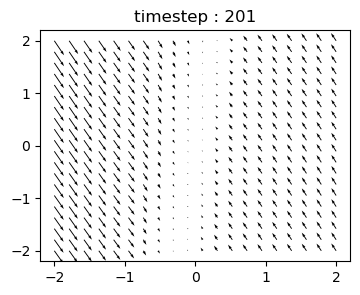

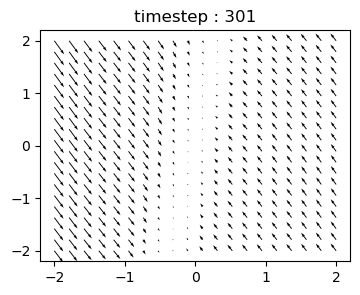

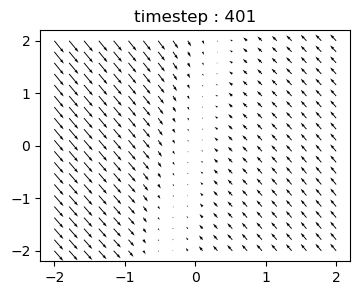

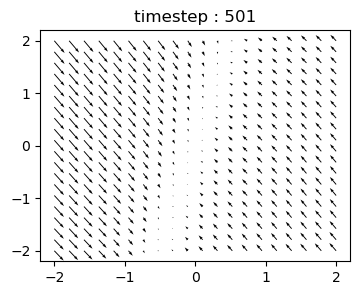

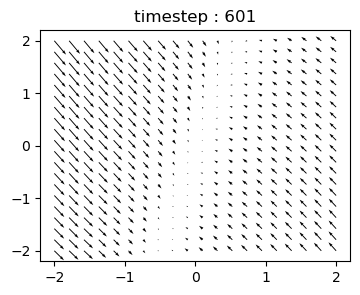

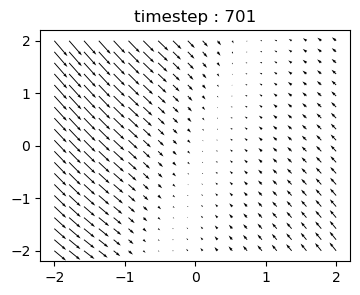

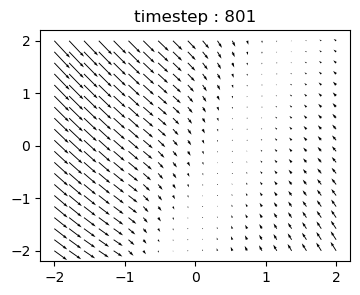

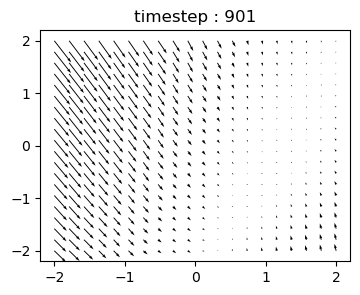

In [119]:
# test 
batch_velocities = jnp.zeros((batch_size, 2, 1))
# Batch_size must be superior to 400 for this test
for timestep in range(1,num_timesteps,100) :
    x,y = np.meshgrid(np.linspace(-2,2,20),np.linspace(-2,2,20))
    X = x.flatten()
    Y = y.flatten()
    batch = np.zeros((batch_size,2,1))
    batch[:400] = np.concatenate( [X[:,None],Y[:,None]], axis = 1)[...,None]
    time_indices = np.ones((batch_size,))*timestep
    scores = score(parameters, batch, batch_velocities, time_indices)[:400]
    u,v = scores[:,0,0], scores[:,1,0]
    plt.figure(figsize=(4,3))
    plt.quiver(x,y,u,v)
    plt.title( "timestep : " + str(timestep))
    plt.show()

In [111]:
@jax.jit
def deterministic_predictor(batch, i, step_size, parameters ) :
    """ 
    - batch : shape (batch_size, 2, dim, 1)
    - i : integer
    - step_size : shape (batch_size,)
    - parameters : dict of parameters for score(...)
    """
    batch_positions = batch[:,0,...] 
    batch_velocities = batch[:,1,...] 
    batch_positions_updated = batch_positions -1.0/M*batch_velocities*beta*step_size[:,None,None] 
    batch_velocities_updated = batch_velocities + batch_positions*beta*step_size[:,None,None]  + 0 + \
                    2*Gamma*( score(parameters, batch_positions, batch_velocities, time_indices[i+1]) + batch_velocities/M )*beta*step_size[:,None,None]

    batch = jnp.concatenate( ( batch_positions_updated[:,None,:,:], batch_velocities_updated[:,None,:,:]), axis = 1)
    return(key, batch)

In [112]:
def timeSteps2stepSize(num_timesteps : int, batch_size : int):
    """ 
    - num_timesteps : int 
    - batch_size : int

    returns :
    - stepSize : shape (num_timesteps, batch_size) 
    """ 
    stepSize = jnp.ones((batch_size,num_timesteps)).T*1.0/num_timesteps
    return(stepSize)

In [113]:
time_indices = jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T

def generate_deterministic_batch(key, parameters, time_indices = time_indices) :
    
    """ 
    - key : PRNG key
    - time_indices : shape (num_timsteps, batch_size) , timsteps are ordered from smallest to biggest
    """

    key1, key = random.split(key)
    
    stepSize = timeSteps2stepSize(num_timesteps, batch_size)
    batch = random.normal(key1, shape = (batch_size, 2, 2,1))*jnp.array([1,M]).reshape((1,-1,1,1)) # prior distribution
    for i in range(num_timesteps- 2, 0, -1) :

        key, batch = deterministic_predictor( batch, i, stepSize[i], parameters )
        batch_positions = batch[:,0,:,:]
        ### test 
        if i%100 == 1 :
          plt.figure(figsize = (4,3))
          plt.scatter(batch_positions[:,0,0], batch_positions[:,1,0], s = 0.2, alpha = 0.7)
          plt.title("step : " + str(i))
          plt.show()
        ###

    return(batch)

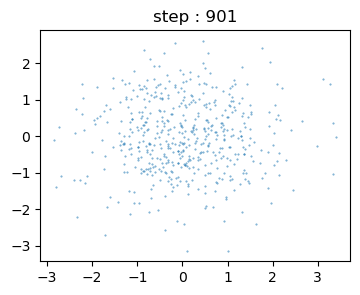

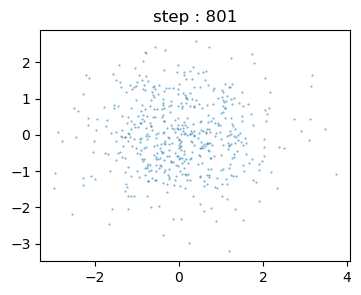

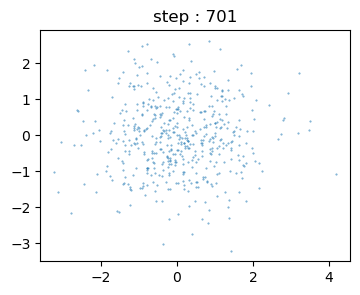

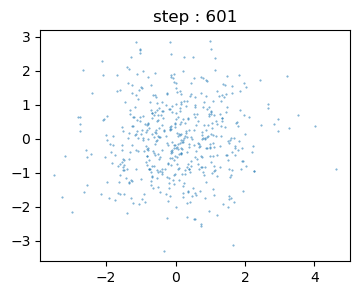

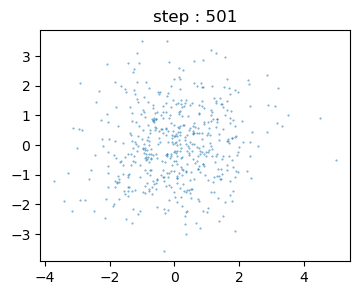

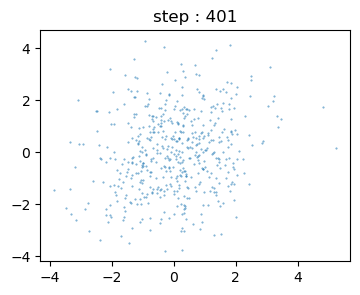

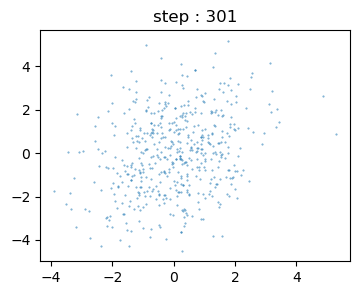

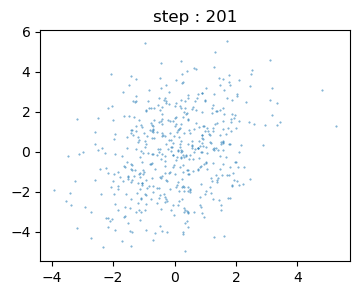

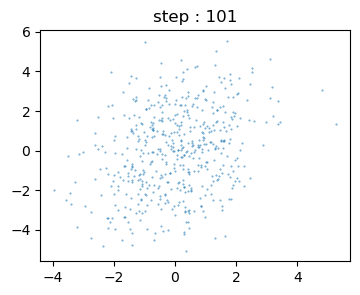

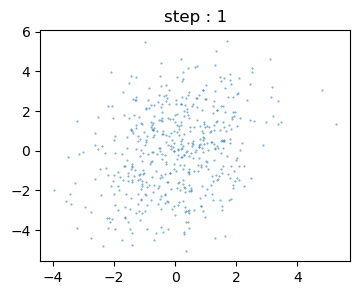

In [114]:
result = generate_deterministic_batch(key, parameters, time_indices = time_indices)

In [115]:
def real_time(t_index) :
    return( t_index*1.0/num_timesteps)

def real_time_dt(t_index) :
    return( jnp.zeros(t_index.shape) + 1.0/num_timesteps)

class MLPDiffusionModel_CLD(nn.Module):
    t_pos_dim: int = 128
    t_embed_dim: int = 128
    x_embed_dim: int = 128
    v_embed_dim: int = 128
    joint_hidden_dim: int = 128

    @nn.compact
    def __call__(
        self,
        u: jnp.ndarray,
        t: jnp.ndarray,
        # cond: jnp.ndarray = None,
        # train: bool = False,
    ):
        
        batch_size = u.shape[0]
        x = u[...,0,0]
        v = u[...,1,0]
        out_dim = x.shape[-1]

        print('t',t.shape)
        print('x',x.shape)

        t_emb = get_timestep_embedding(t, embedding_dim=self.t_pos_dim)
        print("t_embt_emb",t_emb.shape)
        t_emb = FCBlock(hidden_layer=self.t_embed_dim, out_dim=self.t_embed_dim)(t_emb)
        x_emb = FCBlock(hidden_layer=self.x_embed_dim, out_dim=self.x_embed_dim)(x)
        v_emb = FCBlock(hidden_layer=self.x_embed_dim, out_dim=self.x_embed_dim)(v)
        emb = jnp.concatenate([x_emb, t_emb, v_emb], axis=-1)

        vec = FCBlock(hidden_layer=self.joint_hidden_dim, out_dim=out_dim)(emb)
        ### !!! c'est pas l_HSM( real_time(t) c'est L_cholosky !!!!!!!!!!!!!!!!!

        vec = v/((l_HSM( real_time(t) )*Sigma_vv( real_time(t) )).reshape((batch_size,1))) + vec


        return vec
    

def get_random_positions(batch, epsilon,t) :
    # batch shape is (batch_size, 2,1)
    # (batch, 2, dim, 1)  + [ (batch, 2,2) @ (batch,dim ,2,1) -> (batch, 2, dim, 1) ]
    
    return mu_HSM(t,batch) + (L_Cholesky(t).reshape((batch_size,1,2,2))@epsilon.reshape((batch_size,dimension,2,1))).transpose((0,2,1,3))

    
    

est ce que l'input du model doit tjr avoir les mêmes shape ? ça expliquerait beaucoup parce que du coup le truc fait un truc du shape du batch même quand j'envoit un seul élément 

In [116]:


model = MLPDiffusionModel_CLD()
# batch = jnp.ones((batch_size, 2,1)) # the last dimension allows easy matrix multiplication on every point
# t = jnp.zeros(batch_size).flatten()
# parameters = model.init(jax.random.PRNGKey(0), batch, t )

# init training state
# --------------------------------------------
data_shape = (2,dimension,1)
dummy_x = jnp.ones((1, *data_shape))
dummy_t = jnp.ones((1,))
rng, init_rng = jax.random.split(rng)


optimizer_config = config_lib.Config(learning_rate=2e-4) # 2e-4 #, b1=0.9, b2=0.999, eps=1e-8)
optimizer = optax.adam(**optimizer_config.as_dict())
model_vars = model.init(rng, dummy_x, dummy_t)
model_state, params = model_vars.pop("params")
opt_state = optimizer.init(params)

@jax.jit
def loss(parameters, key, batch, t) :

    epsilon = random.normal(key, shape = (batch_size, 2*dimension))
    batch = get_random_positions(batch, epsilon, real_time(t))

    model_return = model.apply({'params': parameters}, batch, t)
    # (batch,d) - (batch,d)
    return(jnp.sum( (epsilon[:,dimension:2*dimension] - model_return )**2) )

NameError: name 'config_lib' is not defined

In [ ]:
# Set up
# --------------------------------------------
# --------------------------------------------

# data
# --------------------------------------------
train_ds, eval_ds = dataset_lib.get_dataset(
    dataset_name,
    train_batch_size=batch_size,
    eval_batch_size=batch_size,
    num_jit_steps=None,
    image_size=None,
    random_flip=None,
    data_category=None,
    uniform_dequantization=False,
    num_two_dim_samples=10_000,
)
train_iter = iter(train_ds)

# set up data transform
transform_fn = lambda x: x

In [ ]:
# training loop
# --------------------------------------------
start_time = time.time()
losses = []
for it in range(num_training_iterations):
    rng, train_rng, time_rng, init_rng = jax.random.split(rng, 4)
    batch = jax.tree_map(lambda x: x._numpy(), next(train_iter))
    x = batch["x"]
    z = transform_fn(x).reshape((batch_size,2,1))

    t = random.randint(key = time_rng, shape = (batch_size,) , minval= 1, maxval = num_timesteps)
    loss_value, grads = jax.value_and_grad(loss)(params, train_rng, z, t)
    # grads = jax.grad(loss)(params, train_rng, z, t)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # metrics
    if it % 500 == 0:
        losses.append(loss_value)
        runtime = time.time() - start_time
        # train_state = flax.jax_utils.unreplicate(pstate)
        
        print_metrics = {"iteration": it, "loss": loss_value, "runtime": runtime}
        loglib.print_metrics(print_metrics)

t (128,)
x (128, 2)
t_embt_emb (128, 128)
iteration: 0 - loss: 148.390076 - runtime: 1.143698
iteration: 500 - loss: 69.910004 - runtime: 14.522703
iteration: 1000 - loss: 74.562080 - runtime: 26.823467
iteration: 1500 - loss: 83.628632 - runtime: 39.140865
iteration: 2000 - loss: 81.609467 - runtime: 51.471512
iteration: 2500 - loss: 81.420364 - runtime: 64.590757
iteration: 3000 - loss: 75.771118 - runtime: 78.223515
iteration: 3500 - loss: 91.304276 - runtime: 91.140064
iteration: 4000 - loss: 70.143631 - runtime: 103.715883
iteration: 4500 - loss: 71.575790 - runtime: 116.250758
iteration: 5000 - loss: 65.433777 - runtime: 129.014274
iteration: 5500 - loss: 71.007553 - runtime: 141.551717
iteration: 6000 - loss: 64.069130 - runtime: 154.107767
iteration: 6500 - loss: 73.334702 - runtime: 166.703548
iteration: 7000 - loss: 76.768555 - runtime: 179.287608
iteration: 7500 - loss: 49.290817 - runtime: 191.961354
iteration: 8000 - loss: 72.459572 - runtime: 204.470182
iteration: 8500 - 

In [ ]:
def score(u,t_indexes) :
    print("lalalalalal", t_indexes.shape)
    return( - l_HSM(real_time(t_indexes))*model.apply( {'params': params} , u ,t) )



In [ ]:
# def Euler_probability_flow_step(u , f , G , score_func , t_index ) :
#     # convention is : T corresponds to the time of the prior distrib p_T and t=0 corresponds to data distrib p_0
#     t = real_time(t_index)
#     return( -f(u, t) + 0.5*G(u,t)@G(u,t).T@score_func(u,t) )

# def Euler_probability_flow_generator(x_T , f , G , score_func , num_timesteps= num_timesteps) :

#     def f(u,t_index) :
#         return (Euler_probability_flow_step(u , f , G , score_func , t_index ),None) # must return a second argument, can be None
#     f_jitted = jax.jit(f)

#     x_0,_ = jax.lax.scan( f_jitted , init = x_T, xs = jnp.array(range(num_timesteps,0,-1)) ) # remember that the score is defined from t_index =1 not from t_index = 0
#     return x_0


In [ ]:
def vectorize_arrays(arrays) :
    result = jnp.array([])
    shapes = []
    for i in range(len(arrays)) :
        shapes.append(arrays[i].shape)
        result = jnp.concatenate( (result , arrays[i].flatten()), axis = 0 ) 
    return(result,shapes)

def unvectorize_arrays(vector,shapes) :
    lengths = [ jnp.prod(jnp.array(shapes[i])) for i in range(len(shapes))]
    cum_sum_lengths = jnp.cumsum(jnp.array([0] + lengths))
    arrays = [ vector[cum_sum_lengths[i] : cum_sum_lengths[i+1]].reshape[shapes[i]] for i in range(len(cum_sum_lengths)-1) ]
    return(arrays)
    


In [ ]:
def Euler_probability_flow_step(u , score_func , t_index_gauss_noise ) :
    # convention is : T corresponds to the time of the prior distrib p_T and t=0 corresponds to data distrib p_0
    # here u is shape (2,1)
    x = u[:,0].squeeze()
    v = u[:,1].squeeze()

    # t_index = t_index_gauss_noise["t_index"]
    # gauss_noise = t_index_gauss_noise["gauss_noise"]
    
    # (t_index,gauss_noise) = unvectorize_arrays(vector = t_index_gauss_noise ,shapes = [ (1,1) , (batch_size,2,1) ])
    t_index = jnp.broadcast_to( t_index_gauss_noise[0].reshape((1,1)) , (batch_size,1))
    print('ici ???', t_index.shape)
    gauss_noise = t_index_gauss_noise[1:].reshape((batch_size, dimension))

    t = real_time(t_index)
    print("la ???", t.shape)
    dt = real_time_dt(t_index)

    print("v",v.shape)
    print("score_func(u,t",score_func(u,t).shape)
    print("beta",beta)

    # score function : (batch,dim)
    # v : (batch,dim,1)
    print("tttt_indexx", t_index.shape)
    C1 = jnp.array( [ [-v/M*beta*dt] , [ (x*beta + Gamma*(score_func(u,t_index) + v/M))*beta*dt  + jnp.sqrt(2*Gamma*beta*dt)*gauss_noise ] ] ).transpose((2,0,3,1 ))  # REVOIR il manque le bruit !!!!!

    print(C1)
    print("C1",C1.shape)
    print("dt",dt.shape)
    values = C1
    
    # 
    return( C1, values )


# def Euler_probability_flow_step(u , score_func , t_index ) :
#     # convention is : T corresponds to the time of the prior distrib p_T and t=0 corresponds to data distrib p_0
#     t = real_time(t_index)
#     dt = real_time_dt(t_index)
#     return(  )

# Euler_probability_flow_step = jax.vmap(Euler_probability_flow_step_one_axis, in_axes= (0,None,None), out_axes=0, axis_name=None, axis_size=None, spmd_axis_name=None)
Euler_probability_flow_step_batch = jax.vmap(Euler_probability_flow_step, in_axes= (0,None,None), out_axes=0, axis_name=None, axis_size=None, spmd_axis_name=None)

def Euler_probability_flow_generator( u_T , score_func , num_timesteps= num_timesteps ) :

    def f(u,t_index_gauss_noise) :
        return Euler_probability_flow_step(u , score_func ,  t_index_gauss_noise ) # must return a second argument, can be None
    f_jitted = f # jax.jit(f) REVOIR 

    rng = jax.random.PRNGKey(seed+1)
    gauss_noise = jax.random.normal(key = rng, shape=(num_timesteps, batch_size, dimension,1))
    t_index =  jnp.array(range(num_timesteps,0,-1)) # jnp.broadcast_to(array = jnp.array(range(num_timesteps,0,-1)).reshape((1,-1,1)) , shape = (batch_size,num_timesteps,1) )
    xs = [ jnp.concatenate( [t_index[i].flatten(),gauss_noise[i].flatten() ], axis = 0) for i in range(num_timesteps) ]
    xs = jnp.array(xs)
    
    x_0, values = jax.lax.scan( f_jitted , init = u_T, xs = xs ) # remember that the score is defined from t_index =1 not from t_index = 0

    print("values", values)
    return x_0

In [ ]:
rng = jax.random.PRNGKey(seed+2)
u_T =  jax.random.normal(key = rng, shape =(128,2,2,1))

x = Euler_probability_flow_generator(u_T = u_T , score_func = score , num_timesteps= num_timesteps)

ici ??? (128, 1)
la ??? (128, 1)
v (128, 2)
lalalalalal (128, 1)
t (128,)
x (128, 2)
t_embt_emb (128, 128)
score_func(u,t (128, 2)
beta 1.0
tttt_indexx (128, 1)
lalalalalal (128, 1)
t (128,)
x (128, 2)
t_embt_emb (128, 128)
Traced<ShapedArray(float32[128,2,2,1])>with<DynamicJaxprTrace(level=1/0)>
C1 (128, 2, 2, 1)
dt (128, 1)
values [[[[[ 8.74938502e-04]
    [-6.79472869e-04]]

   [[ 8.14405605e-02]
    [-9.44498628e-02]]]


  [[[ 1.03333988e-03]
    [ 1.01050758e-03]]

   [[-1.93013567e-02]
    [ 1.84298051e-03]]]


  [[[ 3.07344308e-05]
    [-3.82577622e-04]]

   [[ 1.43039459e-02]
    [ 4.98484783e-02]]]


  ...


  [[[-4.02959879e-04]
    [-1.30092294e-03]]

   [[-4.97617126e-02]
    [ 3.25211580e-03]]]


  [[[ 2.40807756e-04]
    [ 3.33144912e-04]]

   [[-6.05516098e-02]
    [ 2.64423750e-02]]]


  [[[-8.01065529e-04]
    [-1.95932691e-03]]

   [[ 1.01623662e-01]
    [ 6.52780235e-02]]]]



 [[[[-8.14405648e-05]
    [ 9.44498679e-05]]

   [[-4.80535850e-02]
    [ 4.55513271e-03]]]

In [ ]:
# article : flow matching doesn't use stochastic  

import matplotlib.pyplot as plt

In [ ]:
print(x.shape)

(128, 2, 2, 1)


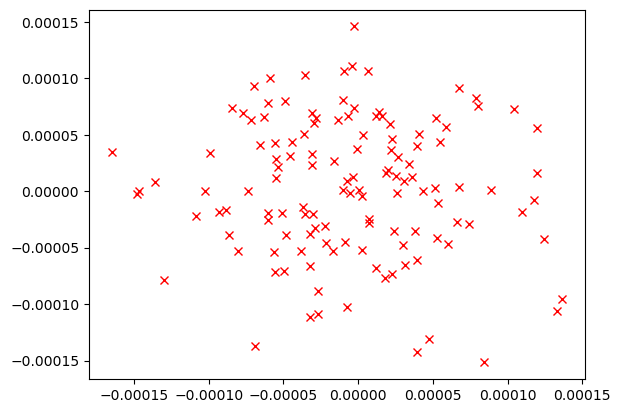

In [ ]:
plot_x = x[:,0,:,0]
plt.plot(plot_x[ :,0], plot_x[:,1], 'rx')

In [ ]:
import numpy as np

In [ ]:
grid_w = 1
res = 50
x,y = jnp.meshgrid(np.linspace(-grid_w,grid_w,res),np.linspace(-grid_w,grid_w,res))
x.shape, y.shape
flat_x = einops.rearrange(x, 'a b -> (a b)')
flat_y = einops.rearrange(y, 'a b -> (a b)')
network_input = jnp.stack([flat_x, flat_y], -1)

t_0 = 0.01
score_fn = score

for t in jnp.arange(t_0, T_max, T_max/10):

    t = jnp.ones(network_input.shape[0])*t
    score = score_fn(x=network_input, t=t)
    dx, dy = jnp.split(score, 2, axis=-1)
    plt.quiver(flat_x, flat_y,dx,dy)
    plt.show()

TypeError: score() got an unexpected keyword argument 'x'

In [ ]:
grid_w = 1
res = 50
x,y = jnp.meshgrid(np.linspace(-grid_w,grid_w,res),np.linspace(-grid_w,grid_w,res))
x.shape, y.shape
flat_x = einops.rearrange(x, 'a b -> (a b)')
flat_y = einops.rearrange(y, 'a b -> (a b)')
network_input = jnp.stack([flat_x, flat_y], -1)
    
for t in jnp.arange(t_0, T_max, T_max/10):

    t = jnp.ones(network_input.shape[0])*t
    score = score_fn(x=network_input, t=t)
    dx, dy = jnp.split(score, 2, axis=-1)
    plt.quiver(flat_x, flat_y,dx,dy)
    plt.show()